In [10]:
import elasticsearch
import pandas as pd

WORKDIR = 'C:/Users/thewr/git/sentiment_analysis_twitter_netflix/'


netflix_tweets_proc_file_test = WORKDIR + '/Data/Processed/netflix_all_tweets_test.parquet'

client = elasticsearch.Elasticsearch('localhost:9200')

client.info()

{'name': 'elastic_node01',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'csxYfu0gRRK6c-e0qb1QHw',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

# *More Like This* Query

- Analisa o texto do parâmetro "like"
- Pega os `max_query_terms` termos mais importantes, de acordo com tf-idf
- Forma uma query com esses termos
- Retorna os documentos mais relevantes

In [2]:
query = {
    "query": {
        "more_like_this": {
            # Campos a serem analizados por semelhança à query
            "fields": [
                "text_cleaned"
            ],
            # Documento que eu quero classificar
            "like": """Meu Deus""",
            
            # Parâmetros para contornar os termos de query
            "min_term_freq": 1,
            "max_query_terms": 40,
        }
    }
}
resp = client.search(index="tweets", body=query, _source=['sentimento'])

## Documentos e seus scores

In [3]:
#for doc in resp['hits']['hits']:
 #   res = '{0:s} {1:s} {2:s}'.format(doc['_id'], str(doc['_source']['sentimento']),str(doc['_score']))
  #  print(res)
    
   # print(f"{doc['_id']} - {doc['_source']['sentimento'] :25s} - Score {doc['_score']}")

In [4]:
for doc in resp['hits']['hits']:
    print(f"{doc['_id']} - {str(doc['_source']['sentimento']):25s} - Score {str(doc['_score'])}")

V6DcingB1rloB9xz1XRj - 2.0                       - Score 9.743908
YKDcingB1rloB9xz0XP4 - 2.0                       - Score 9.7282295
zKDcingB1rloB9xz0XL3 - 2.0                       - Score 8.977959
SaDcingB1rloB9xzymfD - 2.0                       - Score 8.515627
sqDcingB1rloB9xzzWv_ - 2.0                       - Score 8.515627
kaDcingB1rloB9xzzm0C - 2.0                       - Score 8.515627
Y6DcingB1rloB9xz0XDo - 0.0                       - Score 8.515627
laDcingB1rloB9xz0XH1 - 0.0                       - Score 8.515627
OaDcingB1rloB9xz0XL2 - 2.0                       - Score 8.515627
maDcingB1rloB9xz0XL3 - 2.0                       - Score 8.515627


## Votação de categoria por score

In [5]:
# Somando Scores no 10 mais próximos
scores = {}

for doc in resp['hits']['hits']:
    
    sentimento = doc['_source']['sentimento']
    score = doc['_score']
    
    scores[sentimento] = scores.get(sentimento, 0.0) + score

In [6]:
for sentimento, score in sorted(scores.items(), key=(lambda x: x[1]), reverse=True):
    print(f'{str(sentimento):25s} - {score}')


2.0                       - 71.0282315
0.0                       - 17.031254


# Função de Classificação

In [7]:
def classify_newsgroup(like, size=10):
    query = {
        "query": {
            "more_like_this": {
                "fields": [
                    "text_cleaned"
                ],

                "like": like,

                "min_term_freq": 1,
                "max_query_terms": 40,
            }
        }
    }
    
    resp = client.search(index="tweets", body=query, size=size)
    
    # Somando Scores no 10 mais próximos
    scores = {}

    for doc in resp['hits']['hits']:

        sentimento = doc['_source']['sentimento']
        score = doc['_score']

        scores[sentimento] = scores.get(sentimento, 0.0) + score
        
    scores = sorted(scores.items(), key=(lambda x: x[1]), reverse=True)
    
    if not scores:
        return None
    
    return scores[0][0]

In [8]:
classify_newsgroup("""Meu Deus""")

2.0

# Avaliando desempenho com dados do scikit-learn

In [11]:
df_test = pd.read_parquet(netflix_tweets_proc_file_test)

In [12]:
predictions = []

for test_message in df_test['text_cleaned']:
    predictions.append(
        classify_newsgroup(test_message)
    )

In [13]:
len(predictions)

1052

In [14]:
len(df_test['sentimento'])

1052

In [15]:
df_test['sentimento'][:10]

998     0.0
1010    2.0
998     2.0
1001    0.0
1002    0.0
1003    2.0
1004    2.0
1006    2.0
1007    0.0
1008    1.0
Name: sentimento, dtype: float64

In [16]:
import numpy as np
from sklearn.metrics import classification_report

In [17]:
target_pred = zip(df_test['sentimento'], predictions)
target_pred = [x for x in target_pred if x[1] is not None]

targets_validos, predictions_validos = zip(*target_pred)


In [18]:
print(classification_report(targets_validos, predictions_validos))

              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64       567
         1.0       0.82      0.11      0.19        85
         2.0       0.55      0.71      0.62       400

    accuracy                           0.61      1052
   macro avg       0.68      0.48      0.48      1052
weighted avg       0.63      0.61      0.60      1052



In [19]:

%matplotlib inline

import matplotlib.pyplot as plt

In [20]:
from sklearn.metrics import confusion_matrix

In [22]:
labels = np.array(df_test['target_names'])

In [30]:
conf = confusion_matrix(y_true=targets_validos, y_pred=predictions_validos)

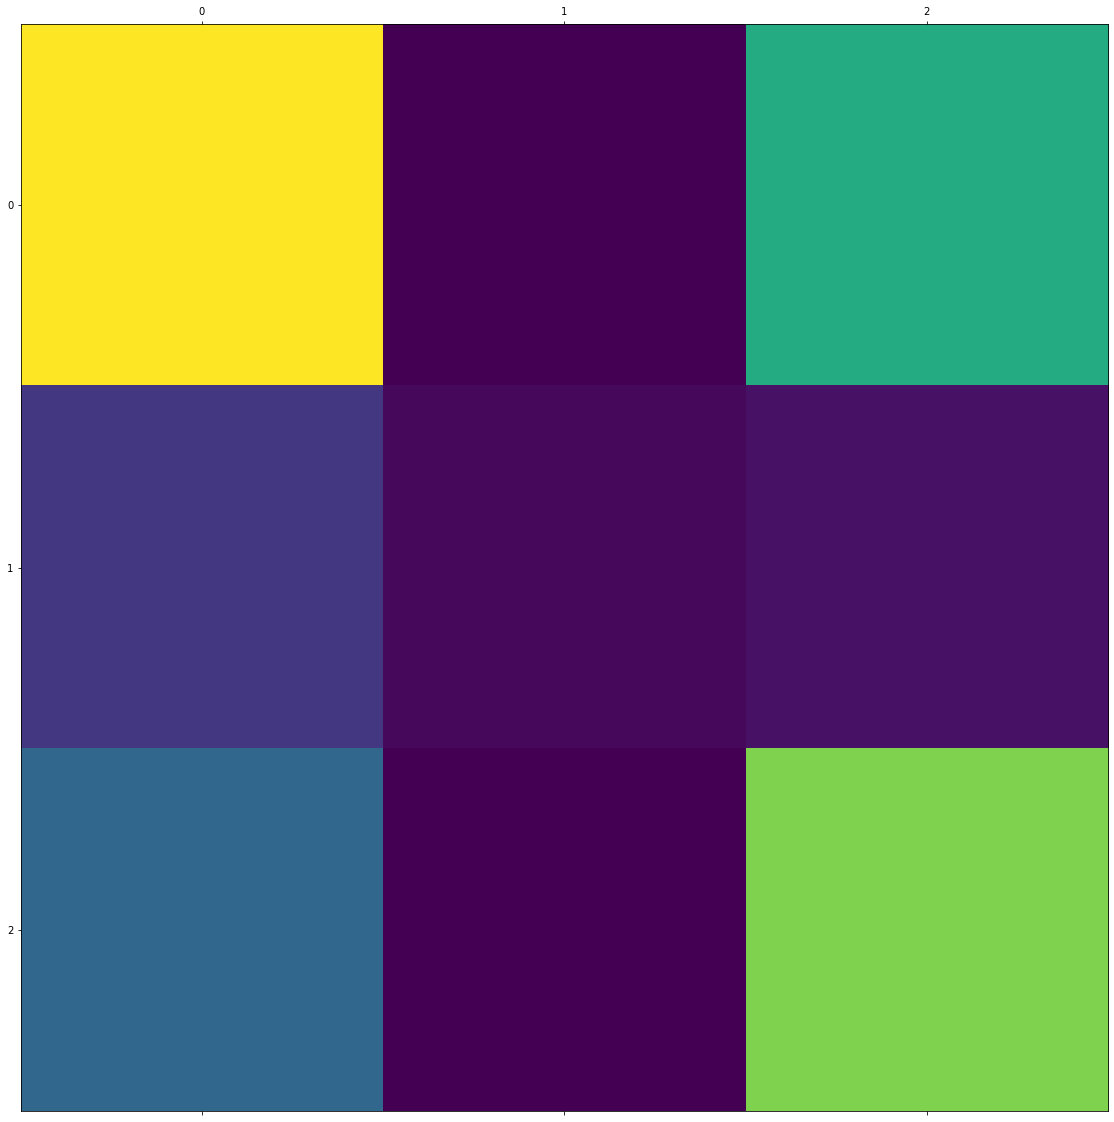

In [31]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(conf)